# 🌶️ Spice Image Classification - Training Pipeline

This notebook provides an interactive interface for training the spice image classification model.

## 📋 Steps:
1. Setup paths and configuration
2. Load and explore dataset
3. Train model
4. Evaluate on test set
5. Generate visualizations

## 1️⃣ Import Libraries and Setup

In [34]:
# Import required modules
import os
import sys
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Import custom modules
from config import Config
from dataset_utils import (
    load_dataset, create_data_splits, create_dataloaders,
    calculate_class_weights, visualize_class_distribution,
    visualize_augmented_samples
)
from model import create_model, print_model_summary, load_checkpoint
from train import Trainer
from evaluation import (
    evaluate_model, plot_training_history, plot_confusion_matrix,
    plot_roc_curves, save_metrics, plot_per_class_metrics,
    find_misclassified_samples, visualize_misclassified
)

# Check GPU availability
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Enable inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

PyTorch Version: 2.10.0+cu128
CUDA Available: True
GPU Device: NVIDIA GeForce GTX 1650
GPU Memory: 4.29 GB


## 2️⃣ Set Paths and Configuration

In [35]:
# ============================================================
# SET YOUR PATHS HERE
# ============================================================

# Path to your dataset (folder containing spice class folders)
DATASET_PATH = "/mnt/n/spiceclassifier/Indian_spices"  # CHANGE THIS!

# Path where outputs will be saved
OUTPUT_PATH = "/mnt/n/spiceclassifier/output"

# ============================================================

# Update config
Config.DATASET_PATH = DATASET_PATH
Config.OUTPUT_PATH = OUTPUT_PATH

# Create output directory
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

print(f"Dataset Path: {DATASET_PATH}")
print(f"Output Path: {OUTPUT_PATH}")
print(f"\nOutput directory created: {output_dir}")

Dataset Path: /mnt/n/spiceclassifier/Indian_spices
Output Path: /mnt/n/spiceclassifier/output

Output directory created: /mnt/n/spiceclassifier/output


## 3️⃣ Configure Training Parameters (Optional)

In [36]:
# Customize training parameters (optional)

# Model selection: 'resnet50', 'efficientnet_b0', 'efficientnet_b3', 'convnext_tiny'
Config.MODEL_NAME = 'efficientnet_b0'

# Training hyperparameters
Config.BATCH_SIZE = 32
Config.NUM_EPOCHS = 50
Config.LEARNING_RATE = 0.001

# Data splits
Config.TRAIN_RATIO = 0.70
Config.VAL_RATIO = 0.15
Config.TEST_RATIO = 0.15

# Features
Config.USE_MIXED_PRECISION = True
Config.EARLY_STOPPING = True
Config.USE_CLASS_WEIGHTS = True

# Print configuration
Config.print_config()

CONFIGURATION
DATASET_PATH                  : /mnt/n/spiceclassifier/Indian_spices
OUTPUT_PATH                   : /mnt/n/spiceclassifier/output
RANDOM_SEED                   : 42
TRAIN_RATIO                   : 0.7
VAL_RATIO                     : 0.15
TEST_RATIO                    : 0.15
MODEL_NAME                    : efficientnet_b0
PRETRAINED                    : True
NUM_CLASSES                   : 19
IMAGE_SIZE                    : 224
NORMALIZE_MEAN                : [0.485, 0.456, 0.406]
NORMALIZE_STD                 : [0.229, 0.224, 0.225]
BATCH_SIZE                    : 32
NUM_EPOCHS                    : 50
LEARNING_RATE                 : 0.001
WEIGHT_DECAY                  : 0.0001
OPTIMIZER                     : adam
SCHEDULER                     : reduce_on_plateau
SCHEDULER_PATIENCE            : 5
SCHEDULER_FACTOR              : 0.5
EARLY_STOPPING                : True
EARLY_STOPPING_PATIENCE       : 10
EARLY_STOPPING_MIN_DELTA      : 0.001
USE_MIXED_PRECISION           : 

## 4️⃣ Load and Explore Dataset

In [37]:
# Load dataset
print("Loading dataset...")
image_paths, labels, class_names, class_to_idx = load_dataset(DATASET_PATH)

# Set number of classes
Config.NUM_CLASSES = len(class_names)

print(f"\n✓ Dataset loaded successfully!")
print(f"Total images: {len(image_paths)}")
print(f"Number of classes: {len(class_names)}")
print(f"\nClasses: {class_names}")

Loading dataset...
Found 19 classes: ['Asafoetida', 'BayLeaf', 'BlackCardamom', 'BlackPepper', 'Carawayseeds', 'Cinnamomstick', 'Cloves', 'CorianderSeeds', 'CubebPepper', 'Cuminseeds', 'DryGinger', 'DryredChilly', 'Fennelseeds', 'GreenCardamom', 'Mace', 'Nutmeg', 'PoppySeeds', 'StarAnise', 'StoneFlowers']
Total images found: 10991

Class distribution:
  Asafoetida               :   364 images
  BayLeaf                  :  1085 images
  BlackCardamom            :   345 images
  BlackPepper              :   278 images
  Carawayseeds             :  1110 images
  Cinnamomstick            :   534 images
  Cloves                   :   827 images
  CorianderSeeds           :   330 images
  CubebPepper              :   325 images
  Cuminseeds               :   360 images
  DryGinger                :   716 images
  DryredChilly             :   841 images
  Fennelseeds              :   428 images
  GreenCardamom            :   401 images
  Mace                     :   854 images
  Nutmeg        

In [38]:
ls /mnt

c/  e/  n/  wsl/  wslg/


Class distribution plot saved to /mnt/n/spiceclassifier/output/class_distribution.png


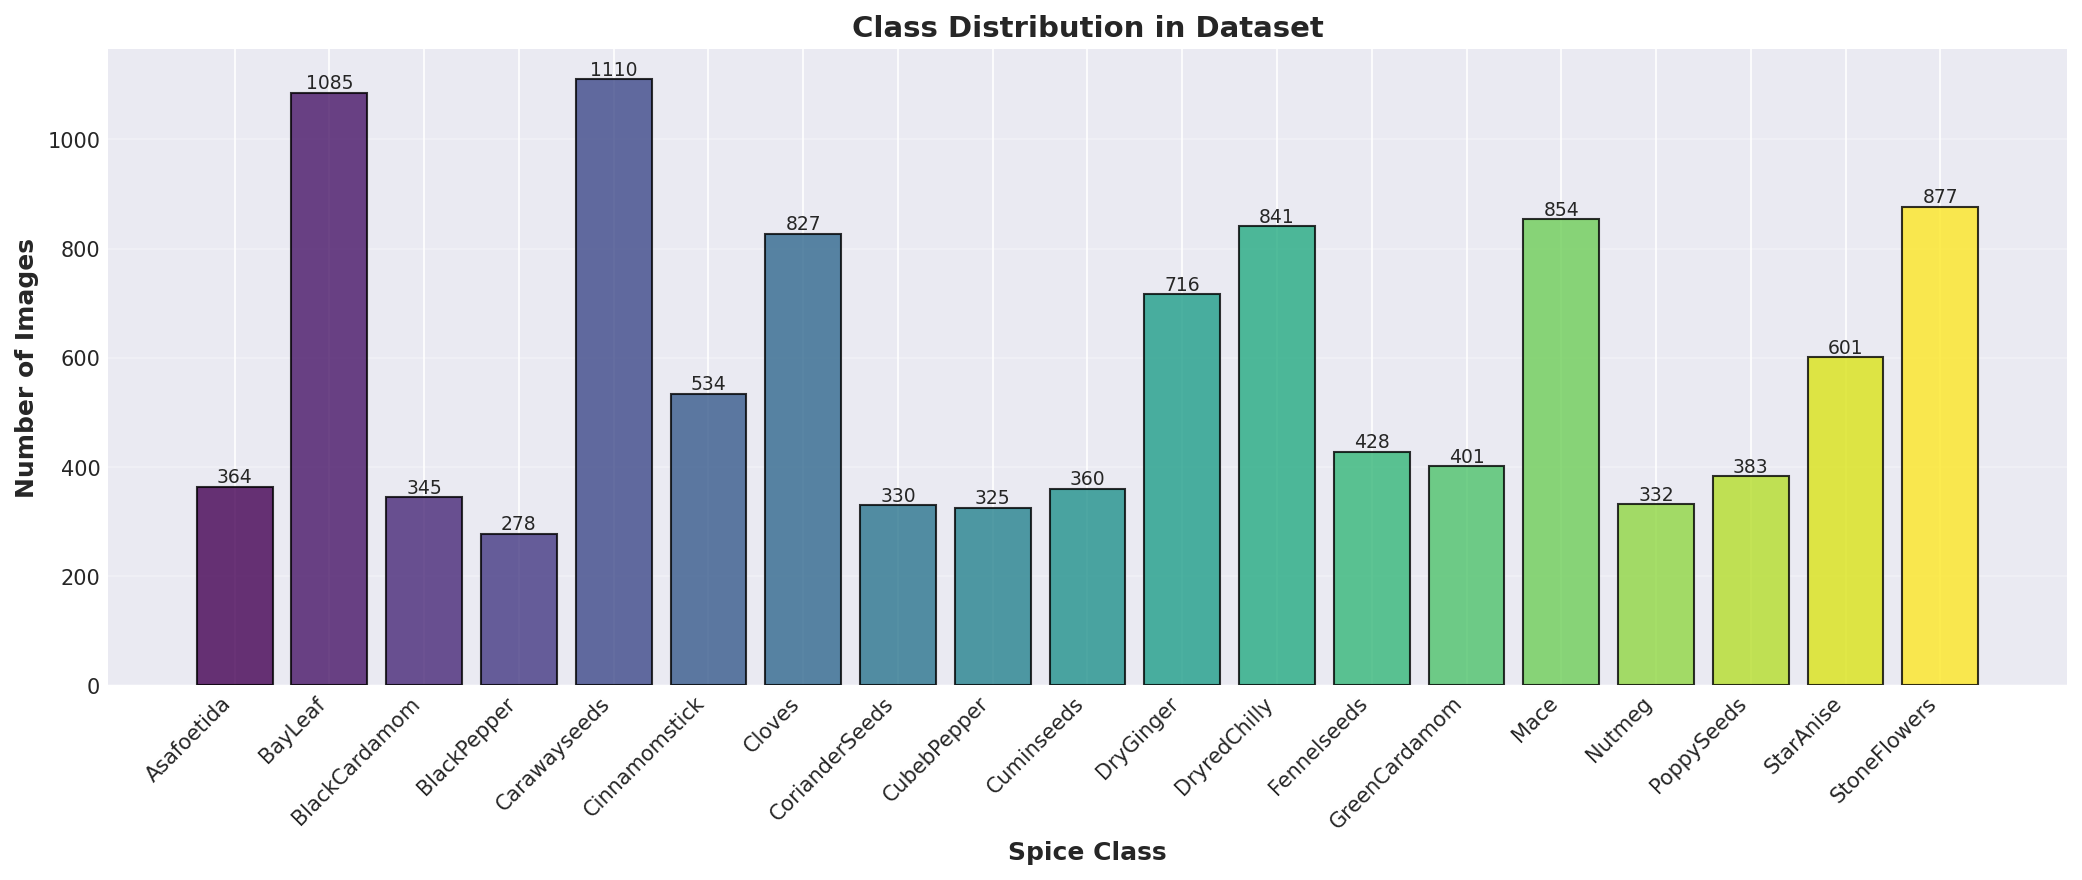

In [39]:
# Visualize class distribution
visualize_class_distribution(
    labels, class_names, 
    output_dir / 'class_distribution.png'
)

# Display the plot
from IPython.display import Image as IPImage
IPImage(filename=str(output_dir / 'class_distribution.png'))

## 5️⃣ Create Data Splits and DataLoaders

In [40]:
# Create train/val/test splits
print("Creating data splits...")
splits = create_data_splits(image_paths, labels, stratify=True)

# Create dataloaders
print("\nCreating dataloaders...")
dataloaders = create_dataloaders(splits, class_names)

print("\n✓ DataLoaders created successfully!")
print(f"Train batches: {len(dataloaders['train'])}")
print(f"Val batches: {len(dataloaders['val'])}")
print(f"Test batches: {len(dataloaders['test'])}")

Creating data splits...

Data split:
  Train: 7693 images (70.0%)
  Val:   1649 images (15.0%)
  Test:  1649 images (15.0%)

Creating dataloaders...

✓ DataLoaders created successfully!
Train batches: 241
Val batches: 52
Test batches: 52


Augmented samples visualization saved to /mnt/n/spiceclassifier/output/augmented_samples.png


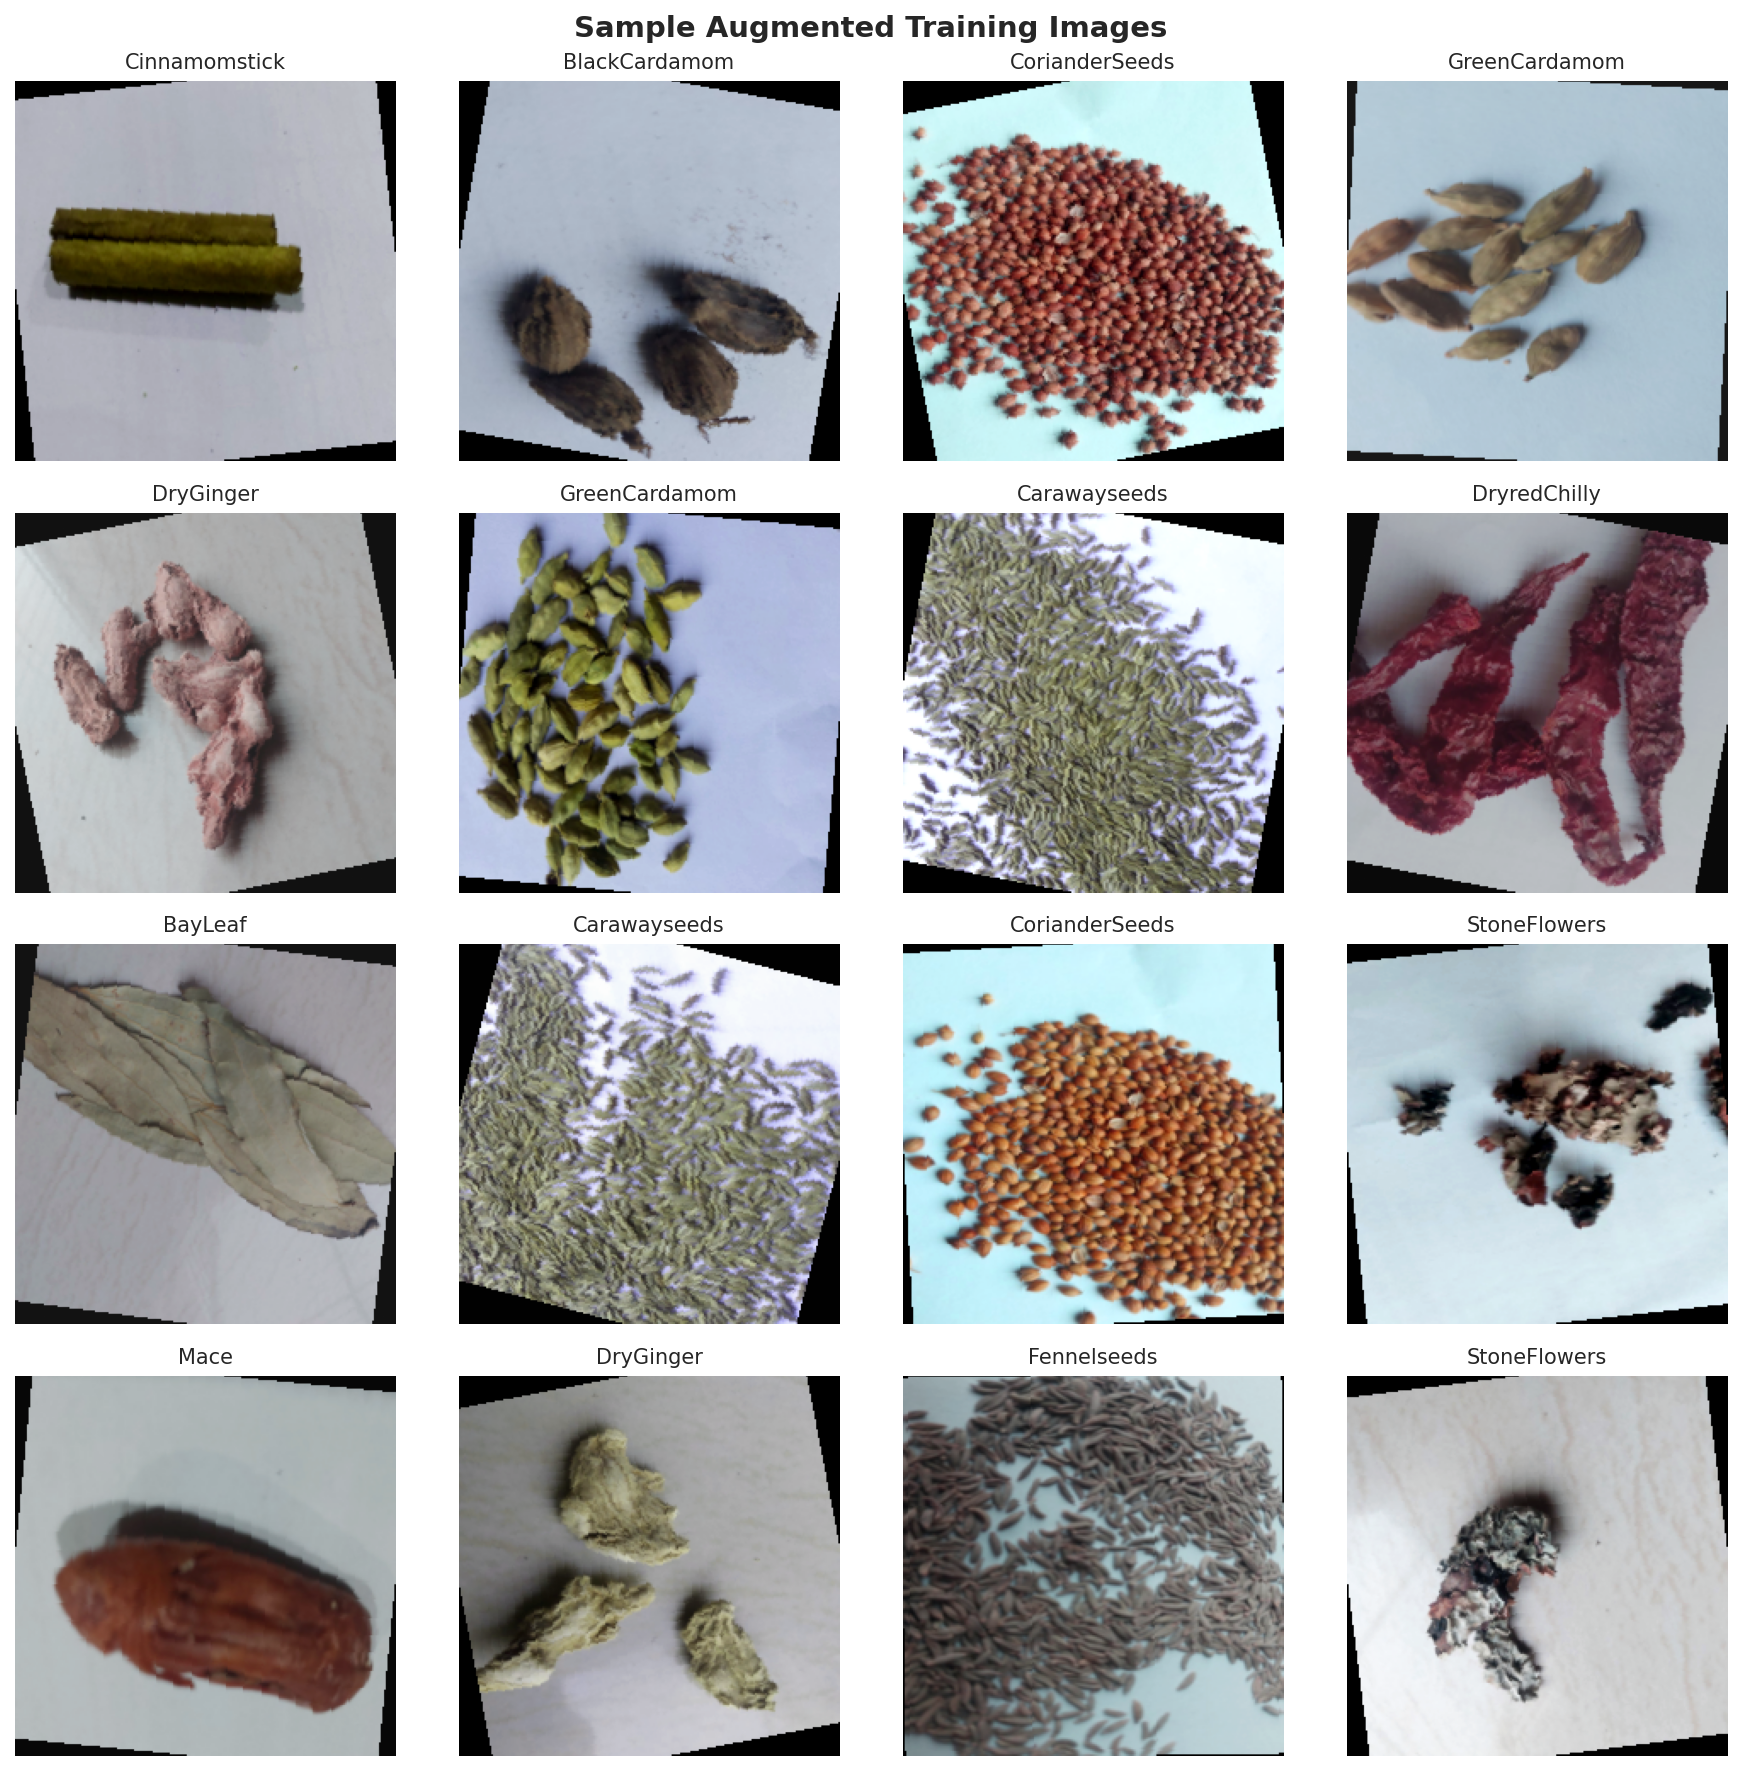

In [41]:
# Visualize augmented samples
visualize_augmented_samples(
    dataloaders['train'], class_names,
    output_dir / 'augmented_samples.png'
)

# Display the plot
IPImage(filename=str(output_dir / 'augmented_samples.png'))

## 6️⃣ Create Model

In [42]:
# Calculate class weights for handling imbalance
class_weights = None
if Config.USE_CLASS_WEIGHTS:
    class_weights = calculate_class_weights(splits['train']['labels'])
    print(f"Class weights calculated: {class_weights.numpy()}")

# Create model
print("\nCreating model...")
model = create_model(Config.NUM_CLASSES)
print_model_summary(model)

Class weights calculated: [1.5940738  0.5334582  1.6800611  2.0870862  0.52110004 1.0826062
 0.69930005 1.752791   1.7836772  1.6067251  0.8065632  0.6874274
 1.3496491  1.4409065  0.6770815  1.7452359  1.5108013  0.9617452
 0.65943766]

Creating model...
Initialized efficientnet_b0 with 19 classes
Model loaded on cuda
Total parameters: 4,031,887
Trainable parameters: 4,031,887

MODEL SUMMARY
Architecture: efficientnet_b0
Number of classes: 19
Device: cuda
Total parameters: 4,031,887
Trainable parameters: 4,031,887
Non-trainable parameters: 0



## 7️⃣ Train Model

This will take some time depending on your hardware and dataset size.

In [43]:
# Save class names
with open(output_dir / 'class_names.json', 'w') as f:
    json.dump({
        'class_names': class_names,
        'class_to_idx': class_to_idx
    }, f, indent=4)

# Save configuration
Config.save_config(output_dir / 'config.json')

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=dataloaders['train'],
    val_loader=dataloaders['val'],
    test_loader=dataloaders['test'],
    class_names=class_names,
    output_dir=output_dir,
    class_weights=class_weights
)

# Start training
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70 + "\n")

history = trainer.train()

print("\n✓ Training completed!")

TensorBoard logging enabled at: /mnt/n/spiceclassifier/output/tensorboard_logs/efficientnet_b0_spice_classification
Start TensorBoard with: tensorboard --logdir /mnt/n/spiceclassifier/output/tensorboard_logs
✓ TensorBoard logging enabled
Using weighted CrossEntropyLoss for class imbalance


/mnt/n/spiceclassifier/files/train.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if Config.USE_MIXED_PRECISION else None



STARTING TRAINING


STARTING TRAINING

Freezing backbone for first 5 epochs
Backbone frozen, classifier unfrozen


Epoch 1/50 [Train]:   0%|                                                           | 0/241 [00:00<?, ?it/s]/mnt/n/spiceclassifier/files/train.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Val]  : 100%|████████████████████████████| 52/52 [00:16<00:00,  3.12it/s, loss=0.0887, acc=98.3]



Epoch 1/50 Summary:
  Train Loss: 0.6253 | Train Acc: 90.38%
  Val Loss:   0.0887 | Val Acc:   98.30%
  LR: 0.001000
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
----------------------------------------------------------------------


Epoch 2/50 [Val]  : 100%|██████████████████████████████| 52/52 [00:16<00:00,  3.09it/s, loss=0.0478, acc=99]



Epoch 2/50 Summary:
  Train Loss: 0.1450 | Train Acc: 96.66%
  Val Loss:   0.0478 | Val Acc:   99.03%
  LR: 0.001000
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
----------------------------------------------------------------------


Epoch 3/50 [Val]  : 100%|████████████████████████████| 52/52 [00:08<00:00,  6.42it/s, loss=0.0454, acc=98.8]



Epoch 3/50 Summary:
  Train Loss: 0.1075 | Train Acc: 97.27%
  Val Loss:   0.0454 | Val Acc:   98.79%
  LR: 0.001000
----------------------------------------------------------------------


Epoch 4/50 [Val]  : 100%|████████████████████████████| 52/52 [00:07<00:00,  6.64it/s, loss=0.0374, acc=99.1]



Epoch 4/50 Summary:
  Train Loss: 0.0864 | Train Acc: 97.73%
  Val Loss:   0.0374 | Val Acc:   99.09%
  LR: 0.001000
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
----------------------------------------------------------------------


Epoch 5/50 [Val]  : 100%|█████████████████████████████| 52/52 [00:07<00:00,  6.55it/s, loss=0.046, acc=98.9]



Epoch 5/50 Summary:
  Train Loss: 0.0714 | Train Acc: 98.18%
  Val Loss:   0.0460 | Val Acc:   98.91%
  LR: 0.001000
EarlyStopping counter: 1/10
----------------------------------------------------------------------

Unfreezing backbone for fine-tuning
Backbone unfrozen for fine-tuning


Epoch 6/50 [Val]  : 100%|████████████████████████████| 52/52 [00:10<00:00,  4.83it/s, loss=0.0107, acc=99.8]



Epoch 6/50 Summary:
  Train Loss: 0.0460 | Train Acc: 98.74%
  Val Loss:   0.0107 | Val Acc:   99.76%
  LR: 0.000100
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
----------------------------------------------------------------------


Epoch 7/50 [Val]  : 100%|███████████████████████████| 52/52 [00:08<00:00,  6.31it/s, loss=0.00202, acc=99.9]



Epoch 7/50 Summary:
  Train Loss: 0.0153 | Train Acc: 99.60%
  Val Loss:   0.0020 | Val Acc:   99.94%
  LR: 0.000100
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
----------------------------------------------------------------------


Epoch 8/50 [Val]  : 100%|████████████████████████████| 52/52 [00:08<00:00,  6.40it/s, loss=0.00103, acc=100]



Epoch 8/50 Summary:
  Train Loss: 0.0101 | Train Acc: 99.70%
  Val Loss:   0.0010 | Val Acc:   100.00%
  LR: 0.000100
✓ Best model saved to /mnt/n/spiceclassifier/output/best_model.pt
EarlyStopping counter: 1/10
----------------------------------------------------------------------


Epoch 9/50 [Val]  : 100%|████████████████████████████| 52/52 [00:08<00:00,  6.31it/s, loss=0.00186, acc=100]



Epoch 9/50 Summary:
  Train Loss: 0.0093 | Train Acc: 99.68%
  Val Loss:   0.0019 | Val Acc:   100.00%
  LR: 0.000100
EarlyStopping counter: 2/10
----------------------------------------------------------------------


Epoch 10/50 [Val]  : 100%|██████████████████████████| 52/52 [00:08<00:00,  6.39it/s, loss=0.000513, acc=100]



Epoch 10/50 Summary:
  Train Loss: 0.0060 | Train Acc: 99.83%
  Val Loss:   0.0005 | Val Acc:   100.00%
  LR: 0.000100
Checkpoint saved to /mnt/n/spiceclassifier/output/checkpoint_epoch_10.pt
----------------------------------------------------------------------


Epoch 11/50 [Val]  : 100%|███████████████████████████| 52/52 [00:08<00:00,  6.35it/s, loss=0.00046, acc=100]



Epoch 11/50 Summary:
  Train Loss: 0.0035 | Train Acc: 99.88%
  Val Loss:   0.0005 | Val Acc:   100.00%
  LR: 0.000100
EarlyStopping counter: 1/10
----------------------------------------------------------------------


Epoch 12/50 [Val]  : 100%|██████████████████████████| 52/52 [00:08<00:00,  6.50it/s, loss=0.000314, acc=100]



Epoch 12/50 Summary:
  Train Loss: 0.0046 | Train Acc: 99.82%
  Val Loss:   0.0003 | Val Acc:   100.00%
  LR: 0.000100
EarlyStopping counter: 2/10
----------------------------------------------------------------------


Epoch 13/50 [Val]  : 100%|██████████████████████████| 52/52 [00:08<00:00,  6.41it/s, loss=0.00117, acc=99.9]



Epoch 13/50 Summary:
  Train Loss: 0.0025 | Train Acc: 99.90%
  Val Loss:   0.0012 | Val Acc:   99.94%
  LR: 0.000100
EarlyStopping counter: 3/10
----------------------------------------------------------------------


Epoch 14/50 [Val]  : 100%|█████████████████████████| 52/52 [00:08<00:00,  6.46it/s, loss=0.000631, acc=99.9]



Epoch 14/50 Summary:
  Train Loss: 0.0046 | Train Acc: 99.86%
  Val Loss:   0.0006 | Val Acc:   99.94%
  LR: 0.000100
EarlyStopping counter: 4/10
----------------------------------------------------------------------


Epoch 15/50 [Val]  : 100%|██████████████████████████| 52/52 [00:08<00:00,  6.49it/s, loss=0.00169, acc=99.9]



Epoch 15/50 Summary:
  Train Loss: 0.0044 | Train Acc: 99.84%
  Val Loss:   0.0017 | Val Acc:   99.88%
  LR: 0.000100
EarlyStopping counter: 5/10
----------------------------------------------------------------------


Epoch 16/50 [Val]  : 100%|█████████████████████████| 52/52 [00:08<00:00,  6.37it/s, loss=0.000922, acc=99.9]



Epoch 16/50 Summary:
  Train Loss: 0.0036 | Train Acc: 99.81%
  Val Loss:   0.0009 | Val Acc:   99.94%
  LR: 0.000100
EarlyStopping counter: 6/10
----------------------------------------------------------------------


Epoch 17/50 [Val]  : 100%|██████████████████████████| 52/52 [00:07<00:00,  6.54it/s, loss=0.000349, acc=100]



Epoch 17/50 Summary:
  Train Loss: 0.0058 | Train Acc: 99.71%
  Val Loss:   0.0003 | Val Acc:   100.00%
  LR: 0.000100
EarlyStopping counter: 7/10
----------------------------------------------------------------------


Epoch 18/50 [Val]  : 100%|█████████████████████████| 52/52 [00:08<00:00,  6.43it/s, loss=0.000747, acc=99.9]



Epoch 18/50 Summary:
  Train Loss: 0.0036 | Train Acc: 99.90%
  Val Loss:   0.0007 | Val Acc:   99.94%
  LR: 0.000100
EarlyStopping counter: 8/10
----------------------------------------------------------------------


Epoch 19/50 [Val]  : 100%|█████████████████████████| 52/52 [00:07<00:00,  6.56it/s, loss=0.000651, acc=99.9]



Epoch 19/50 Summary:
  Train Loss: 0.0055 | Train Acc: 99.86%
  Val Loss:   0.0007 | Val Acc:   99.94%
  LR: 0.000050
EarlyStopping counter: 9/10
----------------------------------------------------------------------


Epoch 20/50 [Val]  : 100%|█████████████████████████| 52/52 [00:08<00:00,  6.41it/s, loss=0.000531, acc=99.9]



Epoch 20/50 Summary:
  Train Loss: 0.0014 | Train Acc: 99.94%
  Val Loss:   0.0005 | Val Acc:   99.94%
  LR: 0.000050
Checkpoint saved to /mnt/n/spiceclassifier/output/checkpoint_epoch_20.pt
EarlyStopping counter: 10/10

Early stopping triggered at epoch 20
Best epoch was 8 with val_acc: 100.00%

TRAINING COMPLETED
Total training time: 35.94 minutes
Best validation accuracy: 100.00% at epoch 8
TensorBoard logger closed
✓ TensorBoard logs saved
Checkpoint saved to /mnt/n/spiceclassifier/output/final_model.pt
Training history saved to /mnt/n/spiceclassifier/output/training_history.csv

✓ Training completed!


## 8️⃣ Visualize Training History

Training curves saved to /mnt/n/spiceclassifier/output/training_curves.png


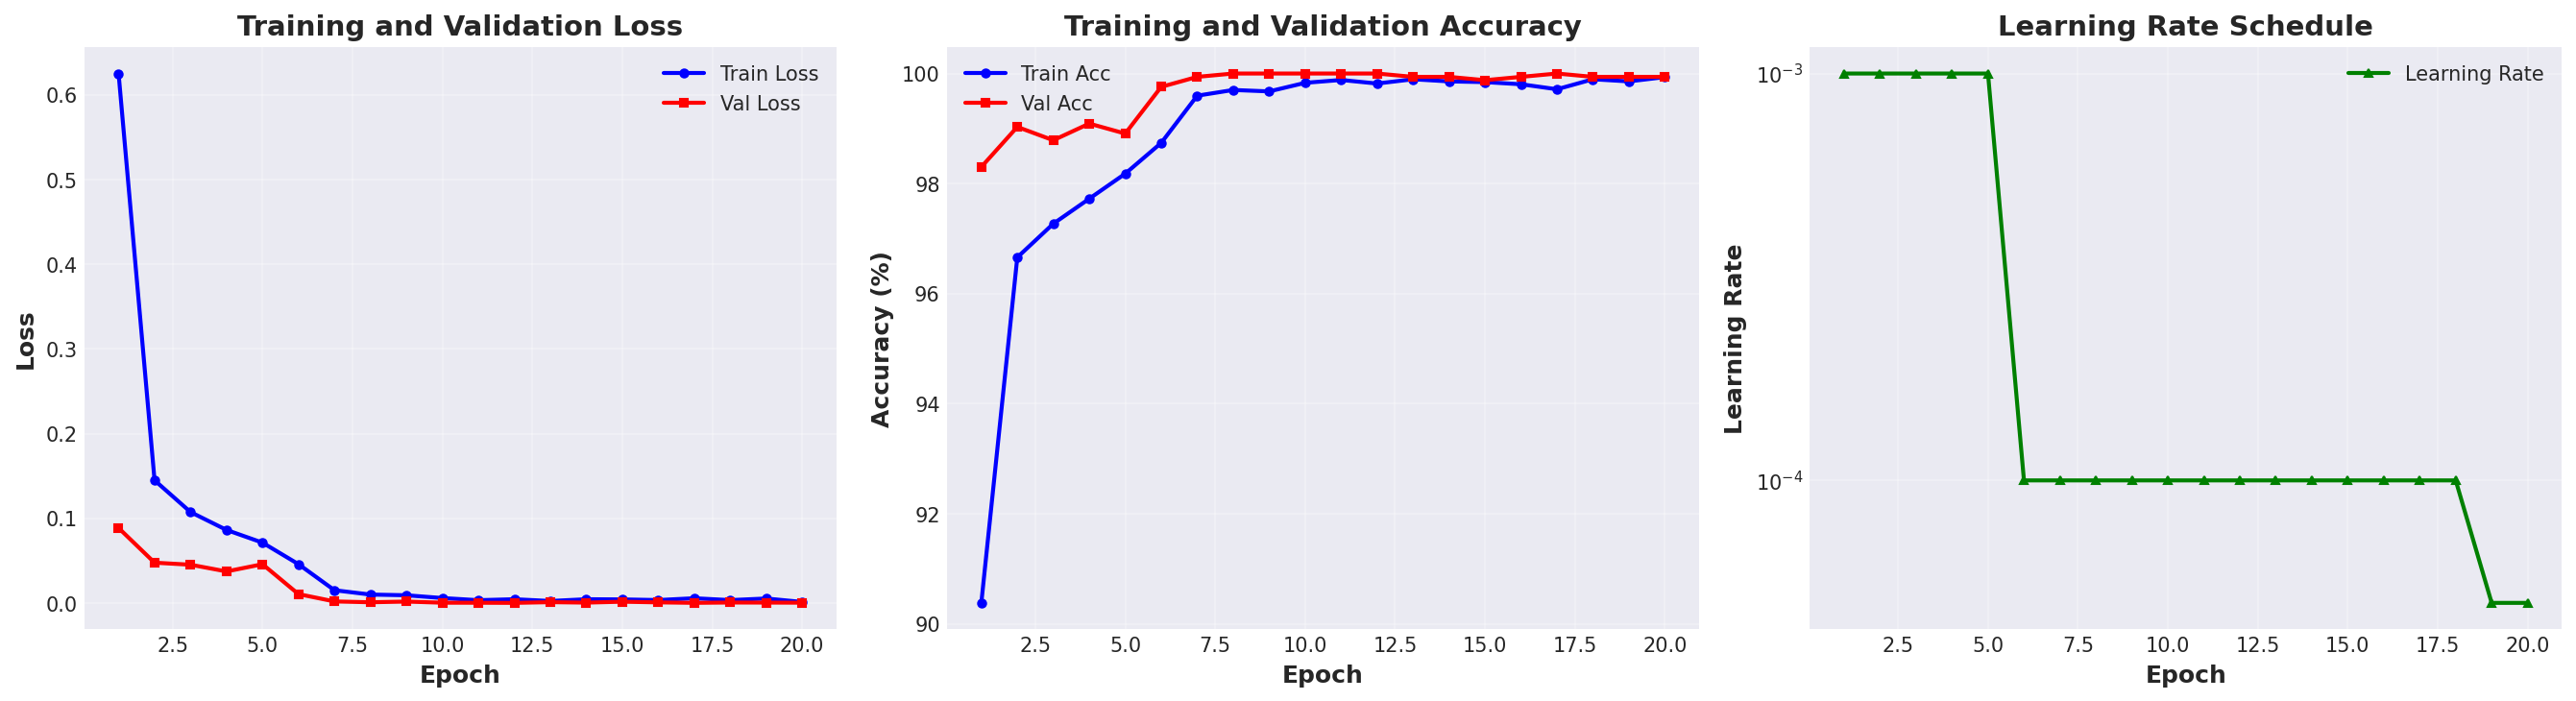

In [44]:
# Plot training curves
plot_training_history(history, output_dir / 'training_curves.png')

# Display the plot
IPImage(filename=str(output_dir / 'training_curves.png'))

## 9️⃣ Evaluate on Test Set

In [45]:
# Load best model
print("Loading best model for evaluation...")
load_checkpoint(output_dir / 'best_model.pt', model)

# Evaluate on test set
print("\nEvaluating on test set...")
metrics = evaluate_model(
    model=model,
    test_loader=dataloaders['test'],
    class_names=class_names,
    output_dir=output_dir
)

# Save metrics
save_metrics(metrics, output_dir / 'test_metrics.json')

print("\n✓ Evaluation completed!")

Loading best model for evaluation...
Checkpoint loaded from /mnt/n/spiceclassifier/output/best_model.pt
  Epoch: 8
  Val Accuracy: 100.0000

Evaluating on test set...
Evaluating model on test set...


Testing: 100%|██████████████████████████████████████████████████████████████| 52/52 [00:12<00:00,  4.27it/s]



TEST SET RESULTS
Accuracy:           0.9994
Precision (macro):  0.9997
Recall (macro):     0.9996
F1 Score (macro):   0.9996
Precision (weighted): 0.9994
Recall (weighted):    0.9994
F1 Score (weighted):  0.9994

Per-Class Metrics:
----------------------------------------------------------------------
Class                     Precision    Recall       F1-Score     Support
----------------------------------------------------------------------
Asafoetida                1.0000       1.0000       1.0000       55
BayLeaf                   0.9939       1.0000       0.9969       163
BlackCardamom             1.0000       1.0000       1.0000       52
BlackPepper               1.0000       1.0000       1.0000       42
Carawayseeds              1.0000       1.0000       1.0000       167
Cinnamomstick             1.0000       1.0000       1.0000       80
Cloves                    1.0000       1.0000       1.0000       124
CorianderSeeds            1.0000       1.0000       1.0000       49
Cubeb

## 🔟 Generate Evaluation Plots

Confusion matrix saved to /mnt/n/spiceclassifier/output/confusion_matrix.png


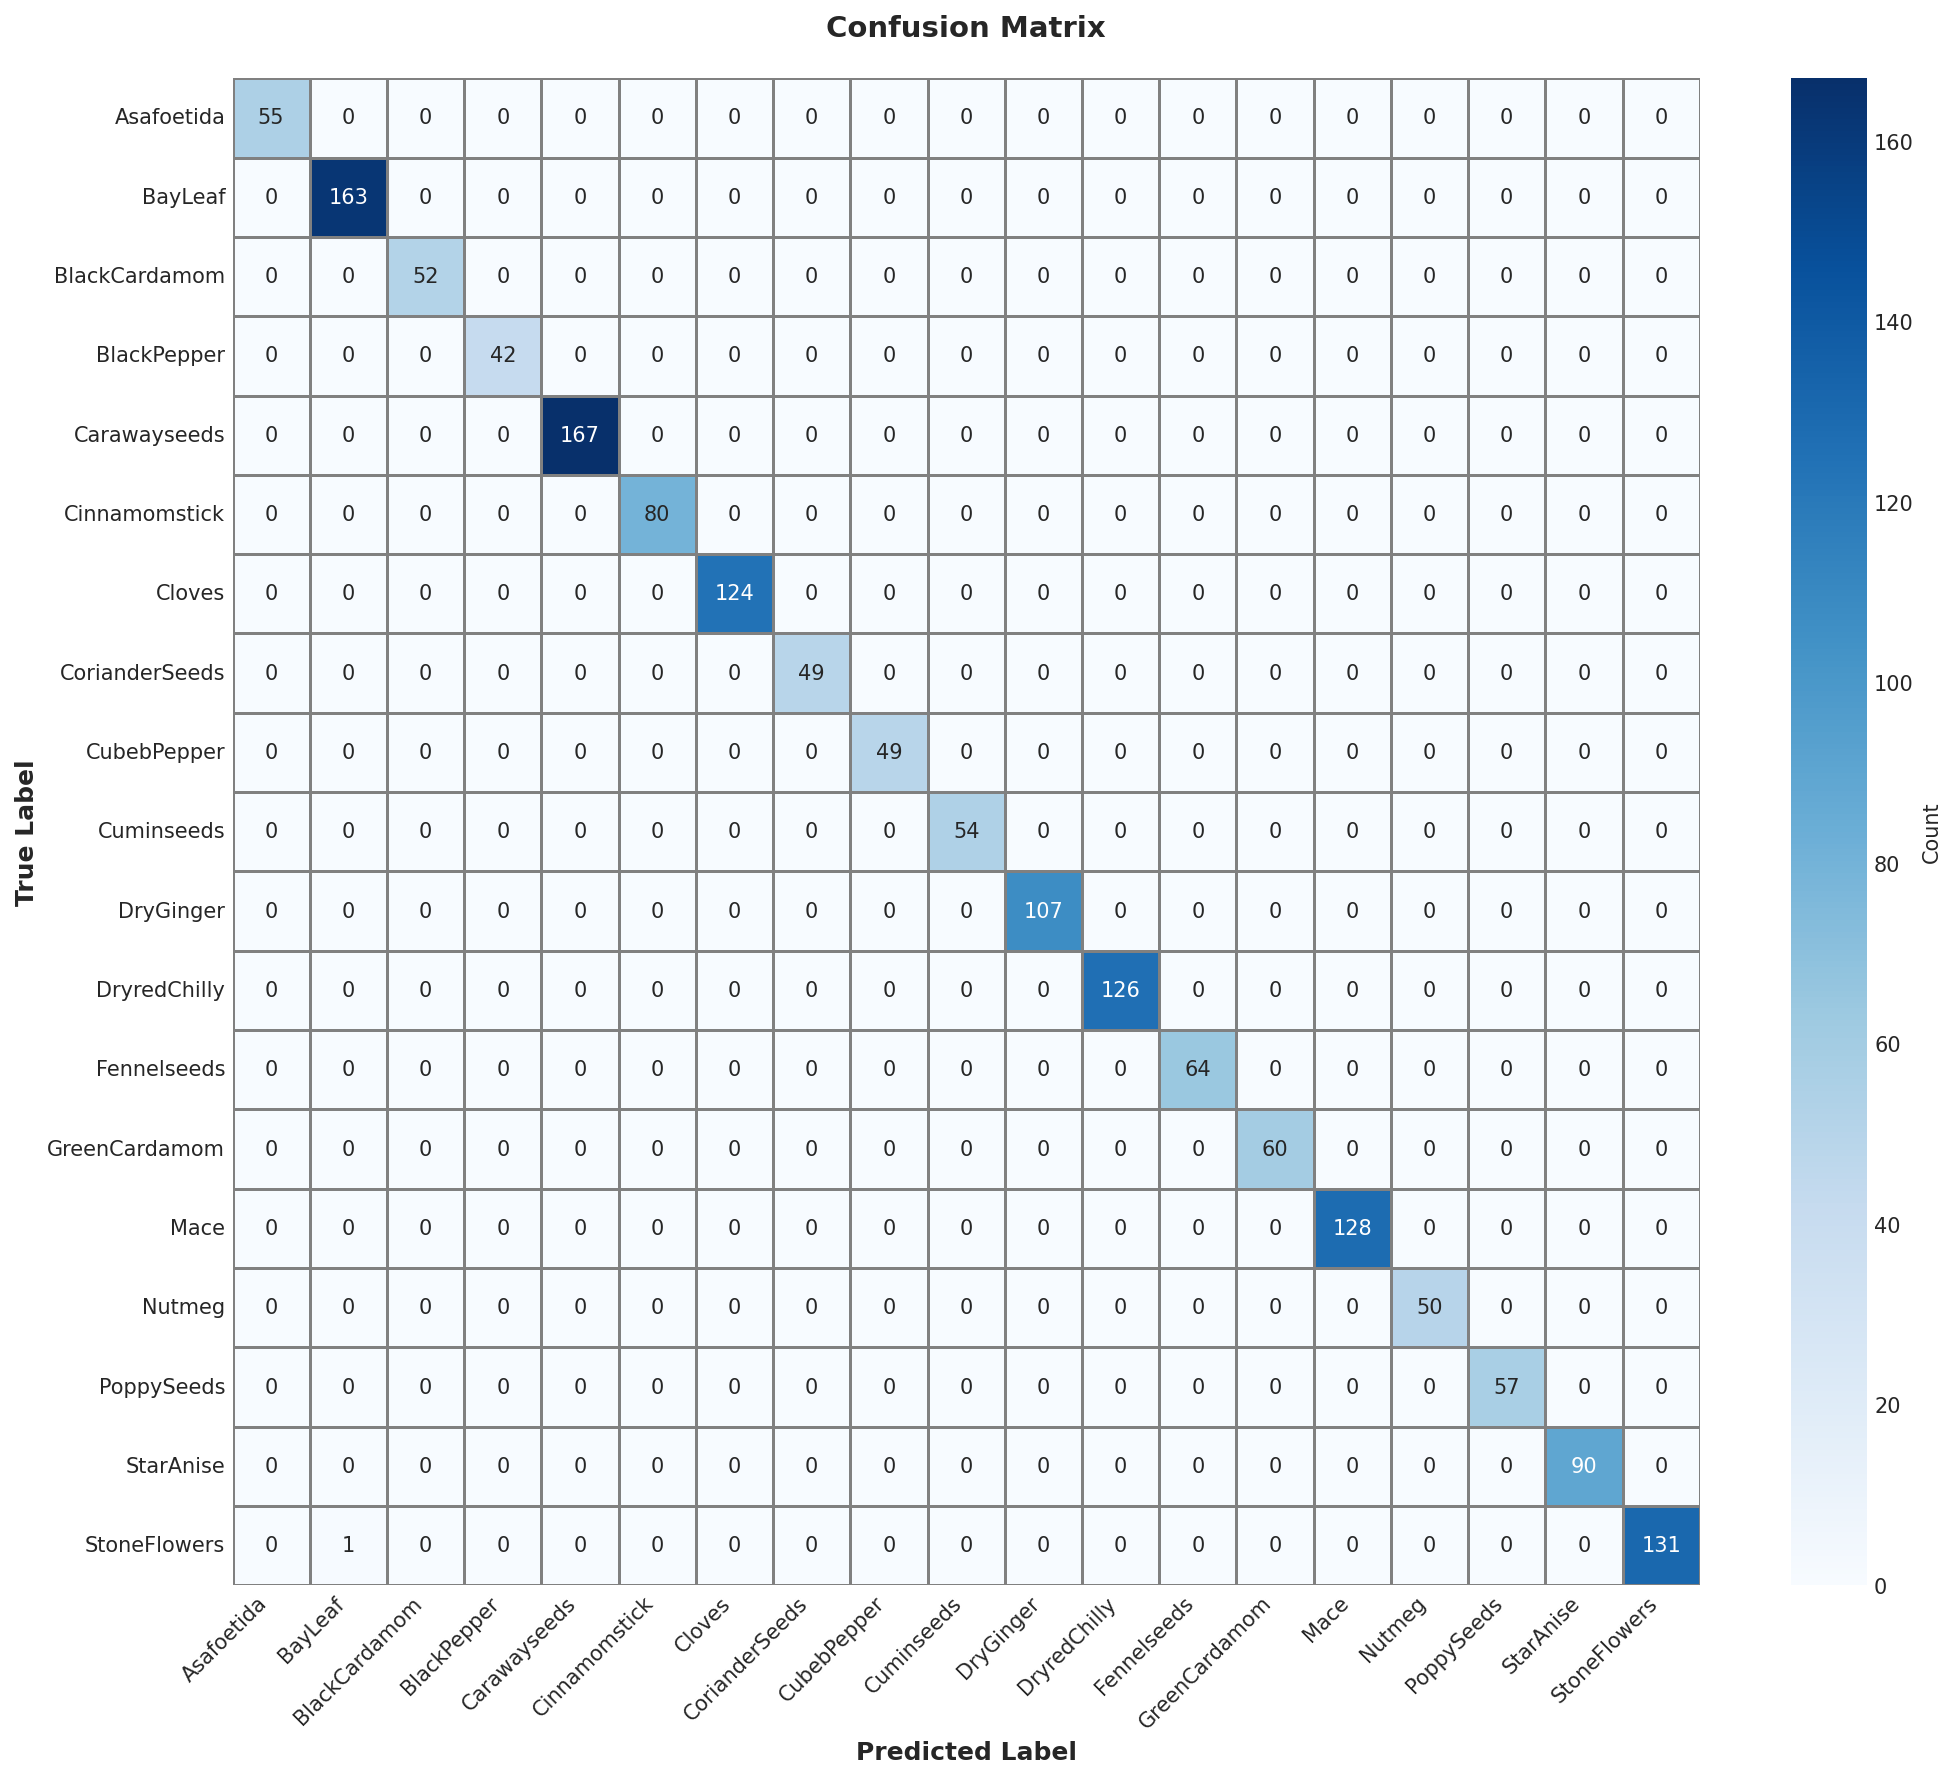

In [46]:
# Confusion Matrix
plot_confusion_matrix(
    metrics['confusion_matrix'],
    class_names,
    output_dir / 'confusion_matrix.png'
)

IPImage(filename=str(output_dir / 'confusion_matrix.png'))

ROC curves saved to /mnt/n/spiceclassifier/output/roc_curves.png


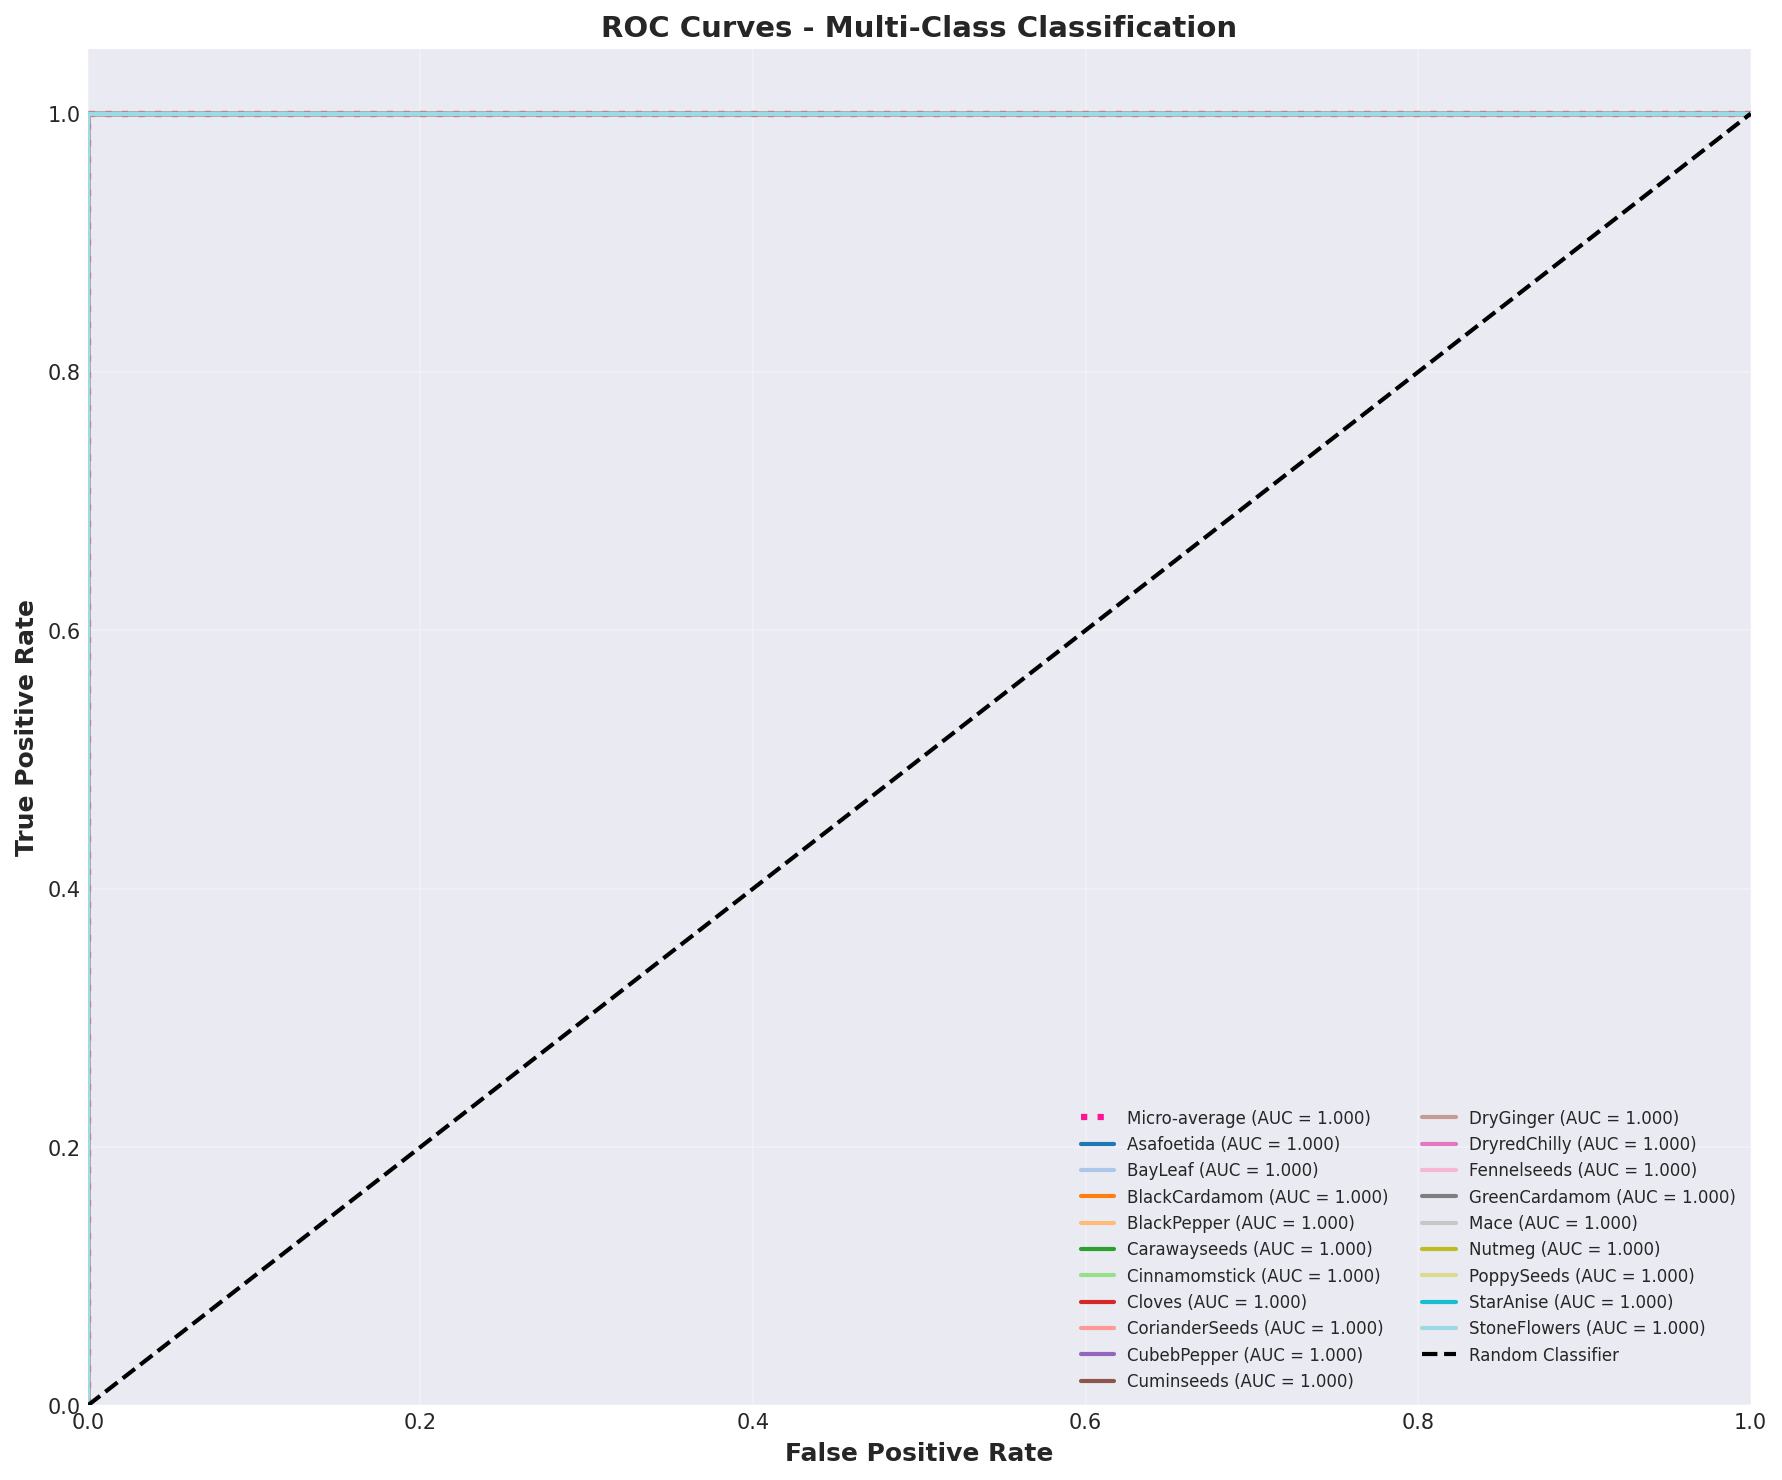

In [47]:
# ROC Curves
plot_roc_curves(
    metrics['all_labels'],
    metrics['all_probs'],
    class_names,
    output_dir / 'roc_curves.png'
)

IPImage(filename=str(output_dir / 'roc_curves.png'))

Per-class metrics plot saved to /mnt/n/spiceclassifier/output/per_class_metrics.png


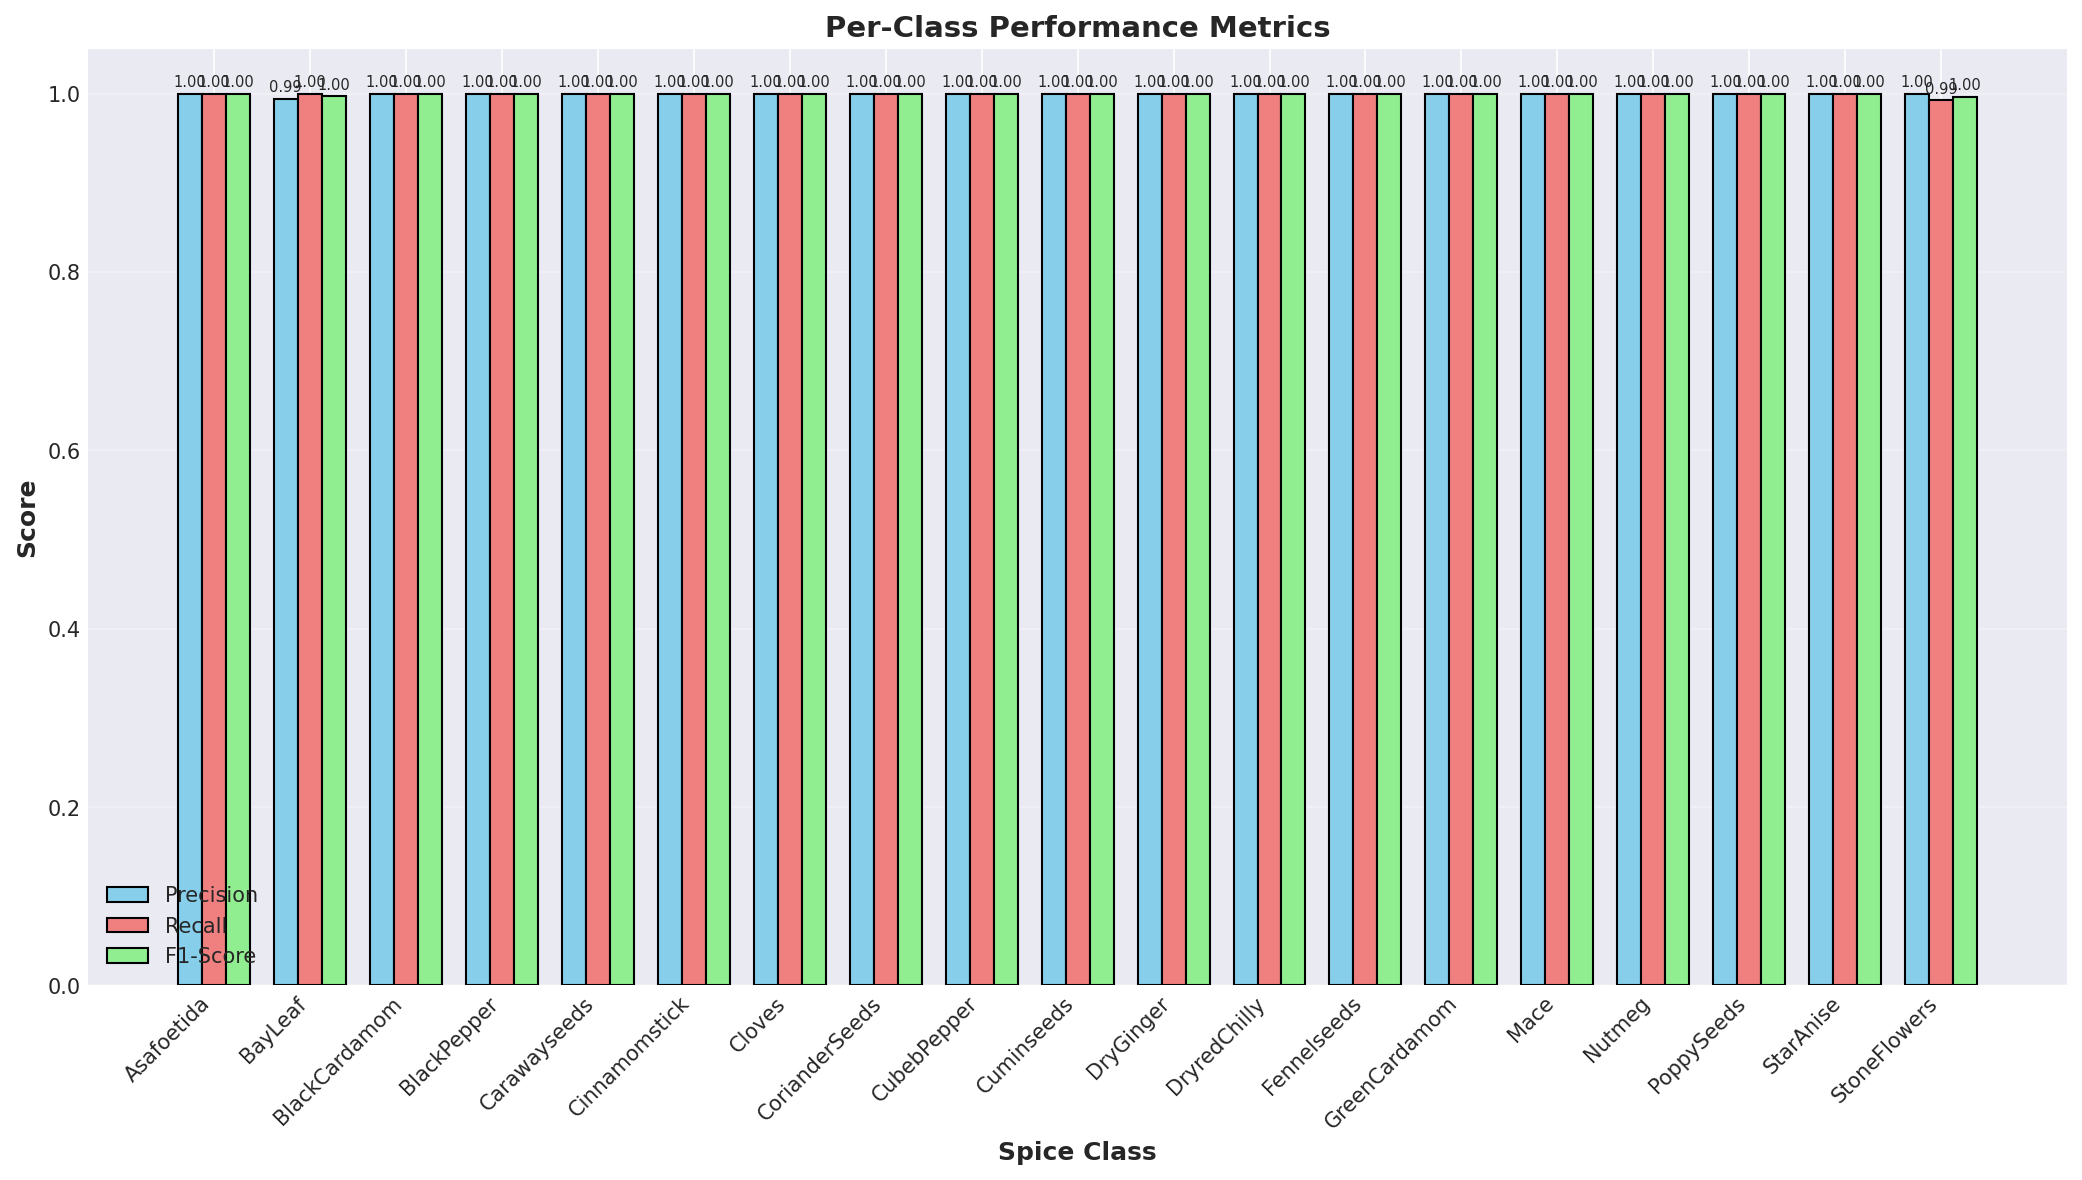

In [48]:
# Per-class metrics
plot_per_class_metrics(
    metrics['classification_report'],
    class_names,
    output_dir / 'per_class_metrics.png'
)

IPImage(filename=str(output_dir / 'per_class_metrics.png'))

## 1️⃣1️⃣ Analyze Misclassified Samples (Optional)

In [49]:
# Find misclassified samples
misclassified = find_misclassified_samples(
    model, 
    dataloaders['test'], 
    class_names, 
    num_samples=16
)

print(f"Found {len(misclassified)} misclassified samples")

# Visualize
if len(misclassified) > 0:
    visualize_misclassified(
        misclassified, 
        output_dir / 'misclassified_samples.png'
    )
    IPImage(filename=str(output_dir / 'misclassified_samples.png'))

Found 1 misclassified samples
Misclassified samples visualization saved to /mnt/n/spiceclassifier/output/misclassified_samples.png


## 1️⃣2️⃣ Generate Grad-CAM Visualizations (Optional)

In [50]:
# Generate Grad-CAM visualizations
if Config.ENABLE_GRADCAM:
    from gradcam import create_gradcam_comparison
    
    print("Generating Grad-CAM visualizations...")
    create_gradcam_comparison(
        model, 
        dataloaders['test'], 
        class_names, 
        output_dir,
        num_samples=8
    )
    
    IPImage(filename=str(output_dir / 'gradcam_comparison.png'))

ModuleNotFoundError: No module named 'cv2'

## ✅ Summary

Training pipeline completed! Check the output directory for all generated files:

- **Models**: `best_model.pt`, `final_model.pt`
- **Metrics**: `test_metrics.json`, `training_history.csv`
- **Plots**: All visualization PNG files
- **Configuration**: `config.json`, `class_names.json`

### Next Steps:
1. Use `predict.py` or `inference_notebook.ipynb` for inference
2. Try different model architectures by changing `Config.MODEL_NAME`
3. Experiment with hyperparameters in `config.py`

In [51]:
# Print final summary
print("\n" + "="*70)
print("TRAINING PIPELINE COMPLETED")
print("="*70)
print(f"\nOutput directory: {output_dir}")
print(f"\nFinal Test Metrics:")
print(f"  Accuracy: {metrics['accuracy']:.4f}")
print(f"  F1 Score (Macro): {metrics['f1_macro']:.4f}")
print(f"  Precision (Macro): {metrics['precision_macro']:.4f}")
print(f"  Recall (Macro): {metrics['recall_macro']:.4f}")
print("="*70)


TRAINING PIPELINE COMPLETED

Output directory: /mnt/n/spiceclassifier/output

Final Test Metrics:
  Accuracy: 0.9994
  F1 Score (Macro): 0.9996
  Precision (Macro): 0.9997
  Recall (Macro): 0.9996
